In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import os
import numpy as np

In [2]:
df_train=pd.read_csv('data/train.csv')
df_test=pd.read_csv('data/test.csv')
df_oil=pd.read_csv('data/oil.csv')
df_hollidays_events=pd.read_csv('data/holidays_events.csv')
df_stores=pd.read_csv('data/stores.csv')
df_transactions=pd.read_csv('data/transactions.csv')


In [3]:
#merge all data to df_train on date
df_train1=pd.merge(df_train,df_oil,on='date',how='left')
df_train1=pd.merge(df_train1,df_hollidays_events,on='date',how='left')
df_train1=pd.merge(df_train1,df_stores,on = 'store_nbr',how='left')
df_train1=pd.merge(df_train1,df_transactions,on = ['date', 'store_nbr'],how='left')
df_train1 = df_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

In [4]:
df_data = pd.concat([df_train, df_test], sort=True)

df_data = df_data.merge(df_stores, how="left", on='store_nbr')   
df_data = df_data.merge(df_oil, how="left", on='date')      
df_data = df_data.merge(df_transactions, how="left", on=['date','store_nbr'])  
df_data = df_data.merge(df_hollidays_events,on='date',how='left')
df_data = df_data.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

df_data.date = pd.to_datetime(df_data.date)
df_data['year'] = df_data['date'].dt.year
df_data['month'] = df_data['date'].dt.month
df_data['week'] = df_data['date'].dt.isocalendar().week
df_data['quarter'] = df_data['date'].dt.quarter
df_data['day_of_week'] = df_data['date'].dt.day_name()
df_data.head()

,date,family,id,onpromotion,sales,store_nbr,city,state,store_type,cluster,...,holiday_type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01,AUTOMOTIVE,0,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
1,2013-01-01,BABY CARE,1,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
2,2013-01-01,BEAUTY,2,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
3,2013-01-01,BEVERAGES,3,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
4,2013-01-01,BOOKS,4,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday


In [5]:
df_data['dcoilwtico'] = df_data['dcoilwtico'].fillna(method='bfill')
df_data.dcoilwtico.isnull().sum()
df_data.transactions = df_data.transactions.replace(np.nan,0)

In [6]:
df_train["date"] = pd.to_datetime(df_train.date)
df_test["date"] = pd.to_datetime(df_test.date)
df_transactions["date"] = pd.to_datetime(df_transactions.date)
df_oil["date"] = pd.to_datetime(df_oil.date)
df_train1["date"] = pd.to_datetime(df_oil.date)


In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
non_numerical_cols =  [col for col in df_data.columns if df_data[col].dtype == 'object']
for feature in non_numerical_cols:        
    df_data[feature] = LabelEncoder().fit_transform(df_data[feature])


In [8]:
df_data.head().style.set_properties(subset=non_numerical_cols, **{'background-color': '#F1C40F'})

,date,family,id,onpromotion,sales,store_nbr,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01 00:00:00,0,0,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,1,4,50,0,2013,1,1,1,5
1,2013-01-01 00:00:00,1,1,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,1,4,50,0,2013,1,1,1,5
2,2013-01-01 00:00:00,2,2,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,1,4,50,0,2013,1,1,1,5
3,2013-01-01 00:00:00,3,3,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,1,4,50,0,2013,1,1,1,5
4,2013-01-01 00:00:00,4,4,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,1,4,50,0,2013,1,1,1,5


In [9]:
df=df_train.set_index(['id']).sort_index()

In [10]:
df.head(5)

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


<AxesSubplot:xlabel='date'>

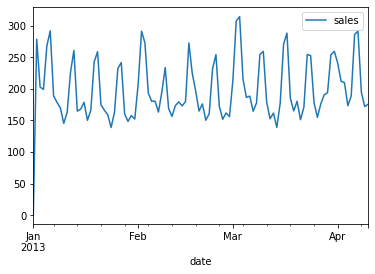

In [11]:
df1=df_train.groupby(df_train.date).mean()[['sales']]
df1[:100].plot()

In [12]:
df1.head(5)

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


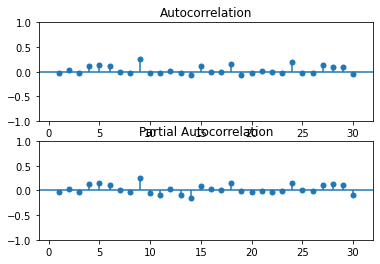

CPU times: user 3h 25min 19s, sys: 9min 36s, total: 3h 34min 56s
Wall time: 54min 33s


In [37]:
%%time
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,ax=plt.subplots(nrows=2,ncols=1)

ax[0].set_title("ACF")
plot_acf(df['sales'].dropna(),lags=30,zero=False,ax=ax[0])
ax[1].set_title("PACF")
plot_pacf(df['sales'].dropna(),lags=30,zero=False,ax=ax[1],method='ywm')
plt.show()

In [16]:
%%time
#sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarimax = SARIMAX(df['sales'], order=(1,0,1))
result_sarimax = model_sarimax.fit(disp=False)


CPU times: user 4min 22s, sys: 7.02 s, total: 4min 29s
Wall time: 4min 23s


In [19]:
predictions_sarimax.shape

(3000888,)

In [20]:
#mean squared error
from sklearn.metrics import mean_squared_error
predictions_sarimax = result_sarimax.predict(start=0, end=len(df['sales'])-1, dynamic=False)
mean_squared_error(df['sales'], predictions_sarimax)

1182069.677855649

In [23]:
predictions_sarimax

id
0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
              ...    
3000883    499.869362
3000884    498.886388
3000885    493.485424
3000886    523.582072
3000887    517.269589
Name: predicted_mean, Length: 3000888, dtype: float64

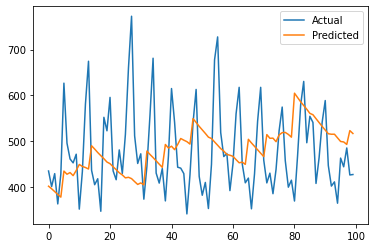

In [36]:
#plot predictions with actual values
plt.plot(df1['sales'][-100:].values, label='Actual')
plt.plot(predictions_sarimax[-100:].values, label='Predicted')
plt.legend()

In [ ]:
# df_data

In [ ]:
atop

In [ ]:
df_train_data=df_data.drop(columns=['id','date'])
df_train_data=df_train_data.dropna()

In [ ]:
df_train_data
X=df_train_data.drop(columns=['sales']).values
y=df_train_data.sales.values

In [ ]:
X = np.asarray(X).astype('float32')
y= np.asarray(y).astype('float32')


In [ ]:
import tensorflow as tf
#simple dnn (input has 19 features)
model=tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=100,input_shape=[19]))
model.add(tf.keras.layers.Dense(units=1))
model.compile(optimizer='adam',loss='mse')
model.fit(X,y,epochs=10,batch_size=4,verbose=2)

In [ ]:
df_test
